# Proyek Analisis Data: Bike Sharing
- **Nama:** Galih Dwi Santiko
- **Email:** gadwisan07@gmail.com
- **ID Dicoding:** Galih Dwi Santiko

## Menentukan Pertanyaan Bisnis

- Bagaimana pola penggunaan sepeda sewa bervariasi berdasarkan musim?
- Apakah ada perbedaan signifikan dalam jumlah sewa sepeda pada hari libur dibandingkan dengan hari biasa?
- Bagaimana pengaruh kondisi cuaca (weathersit) terhadap jumlah sewa sepeda?

## Import Semua Packages/Library yang Digunakan

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Data Wrangling

### Gathering Data

In [2]:
df = pd.read_csv("./Bike-sharing-dataset/hour.csv")
df.shape

(17379, 17)

In [3]:
df.nunique()

instant       17379
dteday          731
season            4
yr                2
mnth             12
hr               24
holiday           2
weekday           7
workingday        2
weathersit        4
temp             50
atemp            65
hum              89
windspeed        30
casual          322
registered      776
cnt             869
dtype: int64

**Insight:**
- Pada Dataset Bike Sharing memiliki 17.379 baris data dan 17 kolom
- Dengan beberapa uniq value setiap kolomnya

### Assessing Data

In [4]:
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [5]:
df.duplicated().sum()

0

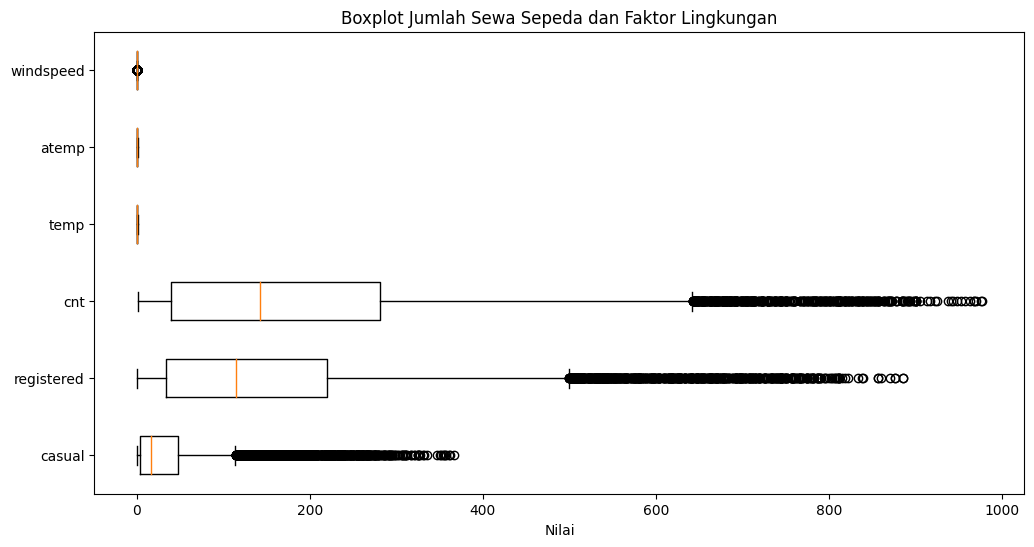


Analisis untuk kolom: casual
Batas Bawah: -62.0
Batas Atas: 114.0
Jumlah Outlier: 1192

Analisis untuk kolom: registered
Batas Bawah: -245.0
Batas Atas: 499.0
Jumlah Outlier: 680

Analisis untuk kolom: cnt
Batas Bawah: -321.5
Batas Atas: 642.5
Jumlah Outlier: 505

Analisis untuk kolom: temp
Batas Bawah: -0.13999999999999996
Batas Atas: 1.1400000000000001
Jumlah Outlier: 0

Analisis untuk kolom: atemp
Batas Bawah: -0.09854999999999997
Batas Atas: 1.0530499999999998
Jumlah Outlier: 0

Analisis untuk kolom: windspeed
Batas Bawah: -0.1193
Batas Atas: 0.4775
Jumlah Outlier: 342


In [6]:
# Menentukan kolom-kolom yang akan dianalisis
columns_to_analyze = ['casual', 'registered', 'cnt', 'temp', 'atemp', 'windspeed']

# Membuat boxplot untuk beberapa kolom
plt.figure(figsize=(12, 6))
plt.boxplot([df[col] for col in columns_to_analyze], vert=False, labels=columns_to_analyze)
plt.title('Boxplot Jumlah Sewa Sepeda dan Faktor Lingkungan')
plt.xlabel('Nilai')
plt.show()

# Menghitung Q1, Q3, dan IQR untuk setiap kolom
for column in columns_to_analyze:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Menentukan batas untuk outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Mencetak batas dan jumlah outlier
    print(f'\nAnalisis untuk kolom: {column}')
    print(f'Batas Bawah: {lower_bound}')
    print(f'Batas Atas: {upper_bound}')

    # Menemukan outlier
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f'Jumlah Outlier: {len(outliers)}')
    #print(outliers)

**Insight:**
- Dataset ini terkategorikan data yang sangat bagus, karena tidak terdapat missing value dan data duplikat
- Namun, terdapat outliers pada beberapa kolom

### Cleaning Data

In [7]:
for column in columns_to_analyze:
    # Kondisi untuk menemukan nilai outlier
    kondisi_lower_than = df[column] < lower_bound
    kondisi_more_than = df[column] > upper_bound

    # Mengganti nilai outlier dengan batas maksimum/minimum
    df[column].mask(kondisi_more_than, upper_bound, inplace=True)
    df[column].mask(kondisi_lower_than, lower_bound, inplace=True)

df[columns_to_analyze].describe()

,casual,registered,cnt,temp,atemp,windspeed
count,17379.000000,17379.000000,17379.0000,17379.000000,17379.000000,17379.000000
mean,0.434061,0.476841,0.4775,0.404211,0.404009,0.188691
std,0.137318,0.017733,0.0000,0.101175,0.100807,0.118197
min,0.000000,0.000000,0.4775,0.020000,0.000000,0.000000
25%,0.477500,0.477500,0.4775,0.340000,0.333300,0.104500
50%,0.477500,0.477500,0.4775,0.477500,0.477500,0.194000
75%,0.477500,0.477500,0.4775,0.477500,0.477500,0.253700
max,0.477500,0.477500,0.4775,0.477500,0.477500,0.477500


**Insight:**
- Karena terdapat beberapa outliers, disini saya menggunakan imputasi untuk langkah penangannannya, agar karakteristik pada kolom lainnya masih tetap bertahan

## Exploratory Data Analysis (EDA)

### Explore ...

In [8]:
# Mengonversi kolom 'season' menjadi label yang lebih mudah dipahami
df['season'] = df['season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})

# Melihat ringkasan total penggunaan sepeda berdasarkan musim
season_summary = df.groupby('season')['cnt'].sum().reset_index()

season_summary

,season,cnt
0,Fall,2146.8400
1,Spring,2025.5550
2,Summer,2105.2975
3,Winter,2020.7800


In [9]:
# Membuat dataframe baru yang merangkum rata-rata penggunaan sepeda pada hari libur dan hari biasa
holiday_summary_df = df.groupby('holiday')['cnt'].sum().reset_index()

# Mengonversi nilai 0 dan 1 pada kolom 'holiday' menjadi lebih deskriptif
holiday_summary_df['holiday'] = holiday_summary_df['holiday'].map({0: 'Workingday', 1: 'Holiday'})

# Menampilkan isi dataframe baru
holiday_summary_df

,holiday,cnt
0,Workingday,8059.7225
1,Holiday,238.7500


In [10]:
# Mengonversi kolom 'weathersit' menjadi label yang lebih mudah dipahami
df['weathersit'] = df['weathersit'].map({
    1: 'Cerah',
    2: 'Kabut',
    3: 'Salju',
    4: 'Hujan deras'
})

# Membuat dataframe baru yang merangkum jumlah penggunaan sepeda berdasarkan kondisi cuaca
weather_summary_df = df.groupby('weathersit')['cnt'].sum().reset_index()

# Menampilkan isi dataframe baru
weather_summary_df

,weathersit,cnt
0,Cerah,5449.7075
1,Hujan deras,1.4325
2,Kabut,2169.7600
3,Salju,677.5725


**Insight:**
- Saya mencoba mengeksplorasi hubungan antara pengaruh cuaca, hari kerja dan cuaca dalam penyewaan sepeda

## Visualization & Explanatory Analysis

### Pertanyaan 1:

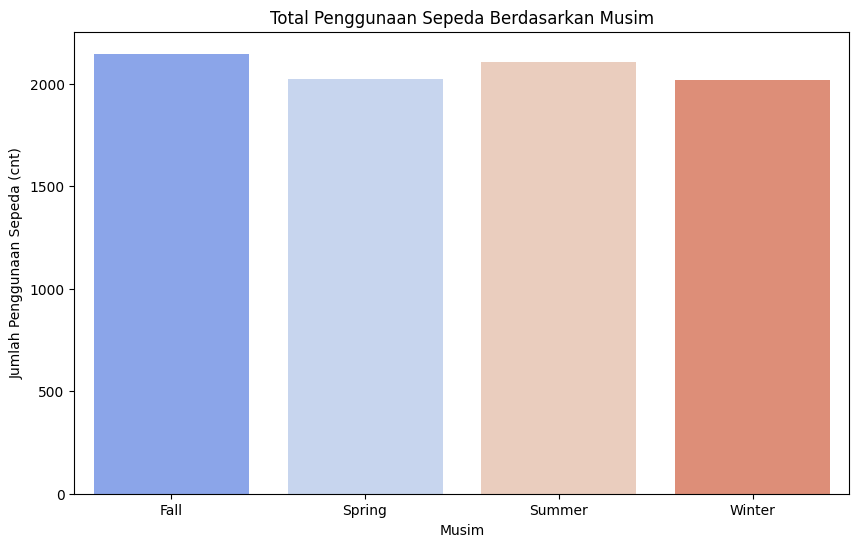

In [11]:
# Visualisasi penggunaan sepeda berdasarkan musim
plt.figure(figsize=(10, 6))
sns.barplot(x='season', y='cnt', data=season_summary, palette='coolwarm')
plt.title('Total Penggunaan Sepeda Berdasarkan Musim')
plt.xlabel('Musim')
plt.ylabel('Jumlah Penggunaan Sepeda (cnt)')
plt.show()

### Pertanyaan 2:

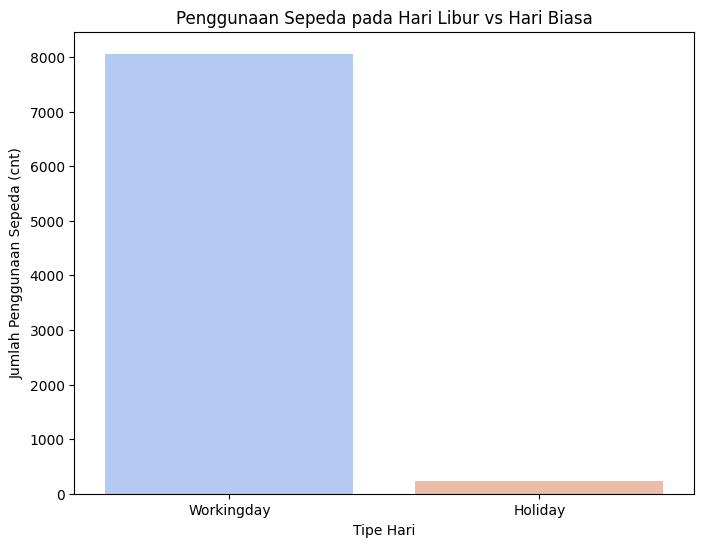

In [12]:
# Visualisasi menggunakan barchart untuk membandingkan jumlah sewa sepeda pada hari libur dan hari biasa
plt.figure(figsize=(8, 6))
sns.barplot(x='holiday', y='cnt', data=holiday_summary_df, palette='coolwarm')
plt.title('Penggunaan Sepeda pada Hari Libur vs Hari Biasa')
plt.xlabel('Tipe Hari')
plt.ylabel('Jumlah Penggunaan Sepeda (cnt)')
plt.show()

### Pertanyaan 3

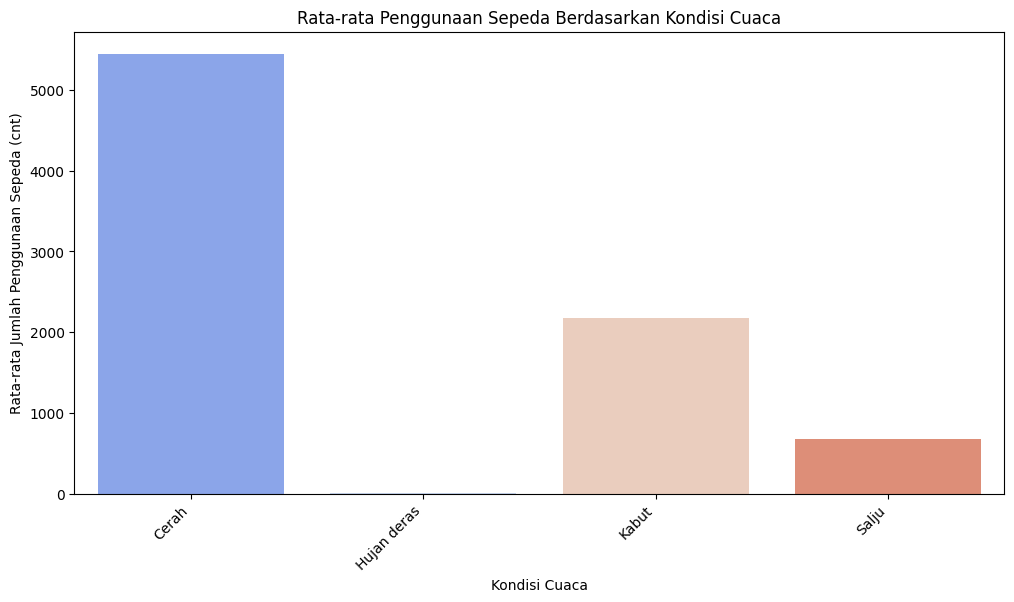

In [13]:
# Visualisasi menggunakan barchart untuk membandingkan rata-rata sewa sepeda berdasarkan kondisi cuaca
plt.figure(figsize=(12, 6))
sns.barplot(x='weathersit', y='cnt', data=weather_summary_df, palette='coolwarm')
plt.title('Rata-rata Penggunaan Sepeda Berdasarkan Kondisi Cuaca')
plt.xlabel('Kondisi Cuaca')
plt.ylabel('Rata-rata Jumlah Penggunaan Sepeda (cnt)')
plt.xticks(rotation=45, ha='right')  # Memutar label untuk visibilitas yang lebih baik
plt.show()

**Insight:**
- Tidak terdapat perbedaan signifikan terhadap pengaruh musim dalam sewa sepeda
- Terdapat pengaruh besar di hari kerja yang dimana membuat sewa ini sangat tinggi dari pada hari libur
- cuaca memiliki pengaruh juga terhadap penyewaan sepeda, dengan dibuktikan sewa menurun ketika cuaca buruk

## Analisis Lanjutan (Opsional)

C:\Users\gadwi\AppData\Local\Temp\ipykernel_4008\4138657066.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  user_counts = df.groupby(['casual', 'registered']).sum()['cnt'].reset_index()


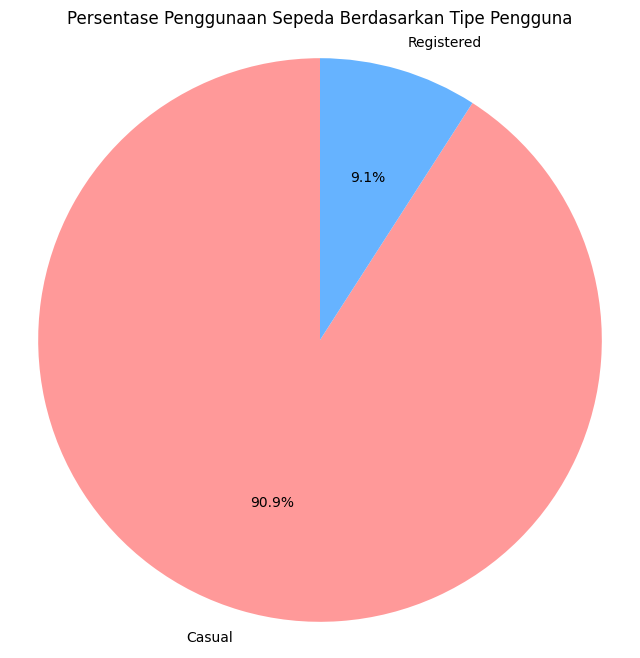

In [15]:
# Segmentasi Pelanggan
# Menghitung total penggunaan sepeda berdasarkan tipe pengguna
user_summary_df = df.groupby(['casual', 'registered'])['cnt'].sum().reset_index()

# Menambahkan kolom untuk tipe pengguna
user_summary_df['user_type'] = user_summary_df.apply(lambda row: 'Casual' if row['casual'] > 0 else 'Registered', axis=1)

# Menghitung total penggunaan untuk setiap tipe pengguna
user_counts = df.groupby(['casual', 'registered']).sum()['cnt'].reset_index()
user_counts['user_type'] = user_counts.apply(lambda row: 'Casual' if row['casual'] > 0 else 'Registered', axis=1)

# Menghitung total penggunaan berdasarkan tipe pengguna
total_counts = user_counts.groupby('user_type')['cnt'].sum()
total_counts
plt.figure(figsize=(8, 8))
plt.pie(total_counts, labels=total_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Persentase Penggunaan Sepeda Berdasarkan Tipe Pengguna')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show() 



## Conclusion

- tidak ada perbedaan signifikan terhadap jumlah sewa setiap musimnya
- Pada hari kerja jumlah sewa jauh lebih tinggi dari hari libur
- cuaca sangat mempengaruhi perilaku pelanggan saat menyewa sepeda, terbukti saat cuaca buruk/hujan deras sangat sedikit yang menyewa sepeda
- dan kebanyakan pengguna adalah pengguna casual bukan terdaftar